In [1]:
from collections import defaultdict
import os.path as op
from cycler import cycler
from glob import glob

import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)
from utils import est_dimensionality

In [2]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)

In [19]:
# tau, include_stp, noise_tau, noise_std, include_corr_noise, p_rel_range
sim_params_all = [[0.01, False, 0.01, 0.0, False, 2],
                  [0.05, False, 0.01, 0.0, False, 2],
                  [0.01, False, 0.01, 0.0, False, 2],
                  [0.01, True, 0.01, 0.0, False, 2],
                  [0.01, False, 0.01, 1e-6, False, 2],
                  [0.01, True, 0.01, 1e-6, False, 2],
                  [0.01, False, 0.01, 1e-6, True, 2],
                  [0.01, True, 0.01, 1e-6, True, 2],
                  [0.01, True, 0.01, 1e-6, False, 1],
                  [0.01, True, 0.01, 1e-6, False, 0]]
sim_type_labels = ['no STP, small tau',
                   'no STP, large tau',
                   'no STP, no noise',
                   'STP, no noise',
                   'no STP + uncorr. noise',
                   'STP + uncorr. noise',
                   'no STP + corr. noise',
                   'STP + corr. noise',
                   'STP + uncorr. noise, low hetero p_rel',
                   'STP + uncorr. noise, homo p_rel']
n_sim_types = len(sim_params_all)

In [4]:
# f_names = glob('/home/ryan/time_coding_output/*.hdf5')
f_names = glob('/home/ryan/Downloads/time_coding_output/*.hdf5')
f_names = sorted(f_names)
n_nets = len(f_names)

loss_curve = list()
hidden_rate_traj = list()
dimensionality = np.zeros((n_nets, n_sim_types))
final_output_traj = list()
for net_idx, f_name in enumerate(f_names):
    with h5py.File(f_name, 'r') as f_read:
        losses = f_read.get('losses')[:]
        loss_curve.append(losses)

        hidden_rates = f_read.get('h_t')[:, 0, :, :]
        hidden_rate_traj.append(hidden_rates)
        for sim_type_idx in range(n_sim_types):
            h_rate_sim_typ = hidden_rates[sim_type_idx, :, :]
            dim = est_dimensionality(h_rate_sim_typ)
            dimensionality[net_idx, sim_type_idx] = dim

        final_outputs = f_read.get('z_t')[:, -1, :, :]
        final_output_traj.append(final_outputs)

# net instance x sim type x learning trial
loss_curve = np.stack(loss_curve)
final_loss = loss_curve[:, :, -1]
# net instance x sim type x time x unit
hidden_rate_traj = np.stack(hidden_rate_traj)
# net instance x sim type x time x unit
final_output_traj = np.stack(final_output_traj)

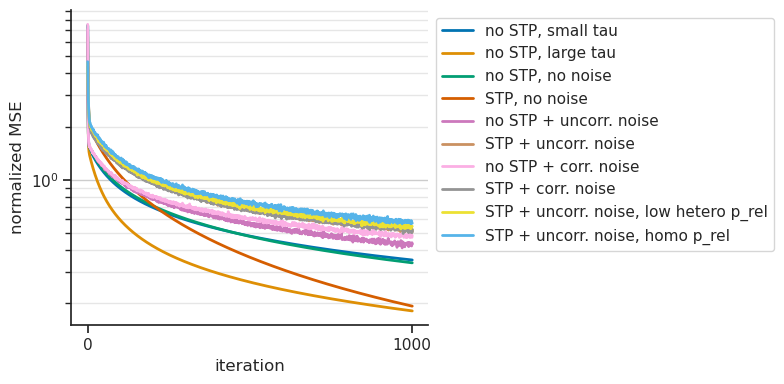

In [34]:
# plot avg learning curve across conditions on one set of axes
cm_hidden = sns.color_palette('colorblind')
fig_learning, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.set_prop_cycle(cycler('color', cm_hidden))

losses_avg = np.mean(loss_curve, axis=0)
trial_idxs = np.arange(loss_curve.shape[2])
for c_idx, sim_type in enumerate(sim_type_labels):
    losses_sim_type = losses_avg[c_idx, :]
    axes.semilogy(trial_idxs, losses_sim_type, lw=2, label=sim_type)
axes.grid(axis='y')
axes.grid(which="minor", color="0.9")
ub_xtick = trial_idxs[-1]
axes.set_xticks([0, ub_xtick])
axes.set_xlabel('iteration')
axes.set_ylabel('normalized MSE')
axes.legend(ncols=1, loc='upper left', bbox_to_anchor=(1, 1))
fig_learning.tight_layout()
fname = 'learning.png'
fig_learning.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_217653/1286987446.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


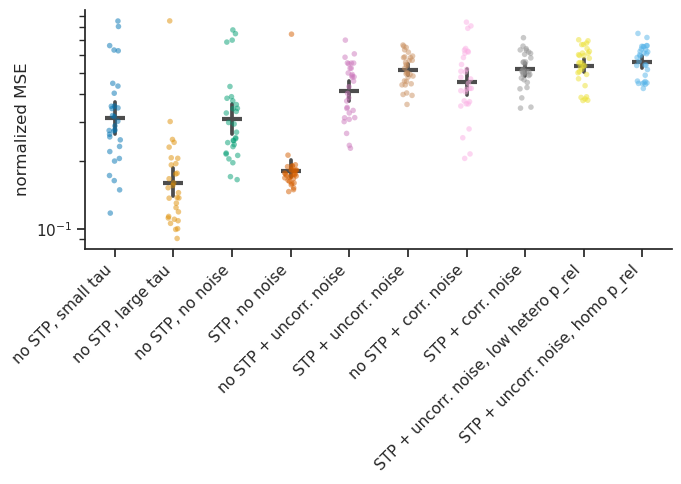

In [33]:
data = {key: final_loss[:, idx] for idx, key in enumerate(sim_type_labels)}
df = pd.DataFrame(data)

fig_final_loss, axes = plt.subplots(figsize=(7, 5))
axes.set_yscale("log")
# sns.violinplot(df, palette='colorblind')
# sns.stripplot(df, size=4, color=".3")
sns.stripplot(df, size=4, palette='colorblind', alpha=0.5)
sns.pointplot(df, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('normalized MSE')
fig_final_loss.tight_layout()

fname = 'final_loss.png'
fig_final_loss.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_217653/1961305855.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


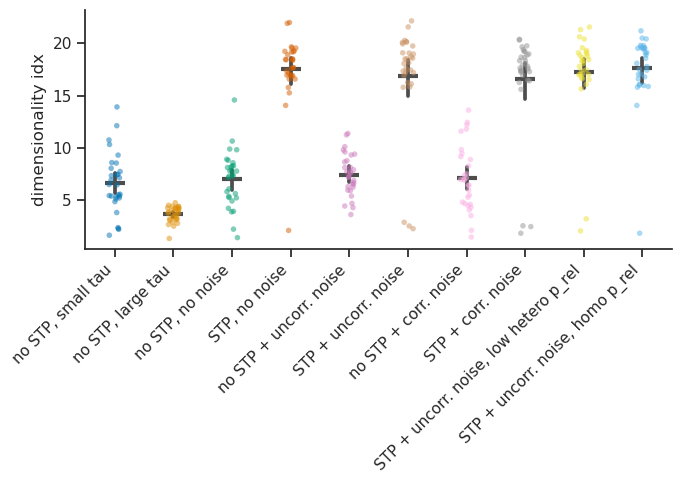

In [32]:
data_dim = {key: dimensionality[:, idx] for idx, key in enumerate(sim_type_labels)}
df_dim = pd.DataFrame(data_dim)

fig_dimensionality, axes = plt.subplots(figsize=(7, 5))
# sns.boxplot(df_dim, fliersize=0, palette='colorblind')
# sns.stripplot(df_dim, size=4, color=".3")

sns.stripplot(df_dim, size=4, palette='colorblind', alpha=0.5)
sns.pointplot(df_dim, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('dimensionality idx')
fig_dimensionality.tight_layout()

fname = 'dimensionality.png'
fig_dimensionality.savefig(op.join('/home/ryan/Desktop', fname))

In [ ]:
# parse data
learning_metrics = defaultdict(list)
learning_metrics['stp'] = param_keys.tolist()
divergences = list()
response_times = list()
perturbation_mags = list()
stp_types = np.repeat(param_keys, 3)

for key in res[0].keys():
    for trial in res:
        if trial[key] is not None:
            if key == 'divergence':
                divergences.extend(trial[key])
            elif key == 'perturbation_mag':
                perturbation_mags.extend(trial[key])
            elif key == 'response_times':
                response_times.extend(np.tile(trial[key], (3, 1)).tolist())
            else:
                learning_metrics[key].append(trial[key])

# fig_divergence, ax = plt.subplots(1, 1, figsize=(3, 3))
# divergence = np.mean(metrics['divergence'], axis=0)
# delay_times = metrics['response_times'][0]
# perturb_mags = metrics['perturbation_mag'][0]
# plot_divergence(divergence, delay_times, perturb_mags, ax=ax)
# fig_divergence.tight_layout()

# plot avg divergence over time for each STP condition w/ error bars
n_times = len(response_times[0])
data = np.array([np.ravel(divergences), np.ravel(response_times),
                 np.repeat(perturbation_mags, n_times),
                 np.repeat(stp_types, n_times)])
div_df = pd.DataFrame(data.T, columns=['MSE', 'time (s)', 'perturbation',
                                       'stp_type'])
fig_divergence, axes = plt.subplots(1, len(param_labels), sharey=True,
                                    figsize=(10, 3))
for stp_type_idx, stp_type in enumerate(param_labels):
    sns.lineplot(data=div_df[div_df['stp_type'] == stp_type], x='time (s)',
                 y='MSE', hue='perturbation', ax=axes[stp_type_idx])
fig_divergence.tight_layout()
fname = 'divergence.png'
fig_divergence.savefig(op.join(output_dir, fname))

# plot avg learning curve across STP conditions on one set of axes
cm_hidden = sns.color_palette('colorblind')
fig_learning, axes = plt.subplots(1, 1, figsize=(4, 3))
axes.set_prop_cycle(cycler('color', cm_hidden))
loss_groupby_stp = defaultdict(list)
for stp_type, losses in zip(learning_metrics['stp'], learning_metrics['losses']):
    loss_groupby_stp[stp_type].append(losses)

for idx, (key, val) in enumerate(loss_groupby_stp.items()):
    losses_avg = np.mean(val, axis=0)
    iter_idxs = np.arange(len(losses_avg))
    axes.semilogy(iter_idxs, losses_avg, lw=2, label=key)
axes.grid(axis='y')
axes.grid(which="minor", color="0.9")
ub_xtick = iter_idxs[-1]
axes.set_xticks([0, ub_xtick])
axes.set_xlabel('iteration')
axes.set_ylabel('normalized MSE')
axes.legend()
fig_learning.tight_layout()
fname = 'learning.png'
fig_learning.savefig(op.join(output_dir, fname))